<div style="background-color:rgb(245, 184, 242); color: rgb(70, 11, 83); border: 2px solidrgb(255, 255, 255); padding: 10px; border-radius: 7px;">
Notes on Utility

With only one bacteria, your only need 1 iteration
1 bacteria in iiFBA == FBA aka you only need one iteration

When you have one organism you will converge in one iteration, which is why is collapses to FBA

No need for time and rates because iterative convergence helps lead to the exact behavior we can expect in the first instance. 
^^ As long as growth is limited only by environmental flux and not internal constraints

If alpha zero, no insight to interaction unless there is cross-feeding, in which the consumer will consume after the first iteration
</div>

<div class="alert alert-block alert-info">
<b> Notes I am realizing: </b>

Maybe only acceptable for Alpha = 0: no chemostat when starting, Alpha=zero gives growth of interaction at start

Using a cumulative sum to plot:
- Alpha=0, asymptote: y=c (horizontal line)
- Alpha!=0, asymptote: y=mx+b (sloped line)

<i> Will convergence point describe initial slope of dFBA? </i>

<i>Could flux sampling give more insight? (especially for situation 2?)</i>

This removes need for explaining relative abundance (haven't actually updated time step, recursive method for understanding initial interactions) **Maybe this is a competitor for compartmentalized FBA** Argument being it is easier to run than needing to update all models' c compartments to be unique and combine.

<i> **I am unsure on Situation 2 & 5**
Should the model use B? If so how do I get model to create B and use it to make biomass, without taking it back in immediately? </i>




</div>
<img src="SImple_Models/iifba_diagram_v1.png" width="2000" height="200">

<div class= "alert alert-block alert-success">
My future steps: <br>
- Run compartmentalized FBA to compare how growth compares. <br>
- Run dFBA to see if convergence point matches slope at t=0? <br>
- Plotting sampling (unimportant)
- 
<br>
Currently working on: <br>
working on making walkthrough ipynb for using package<br>

pip installable!!! (will add to pyPI when done-done)<br>
pip install "git+https://github.com/m-3-lab/iiFBA.git@main#subdirectory=package"

I have models drawn (will be updated and cleaned up if approved- thank you to Violett) Also available in Github Repo Examples >> SImple_Models >> iifba_diagram_v1.png
</div>

# Simple Models Implementation iiFBA



1
Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [1.]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Media: {'Ex_A': -10}
Ex_A: A_e <-- 
T_A: A_e <=> A_c
BiomassOrg1: A_c <=> bio1
exchangeBio1: bio1 <=> 

2
Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [1.]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Media: {'Ex_A': -10, 'Ex_B': -10}
Ex_A: A_e <=> 
Ex_B: B_e --> 
T_A: A_e <=> A_c
T_B: B_c <=> B_e
BiomassFromA: A_c --> B_c + bio1
BiomassFromB: B_c --> bio1
exchangeBio1: bio1 --> 

3
Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [0.5 0.5]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Media: {'Ex_A': -10}
Ex_A: A_e <-- 
T_A: A_e <=> A_c
BiomassOrg1: A_c <=> bio1
exchangeBio1: bi

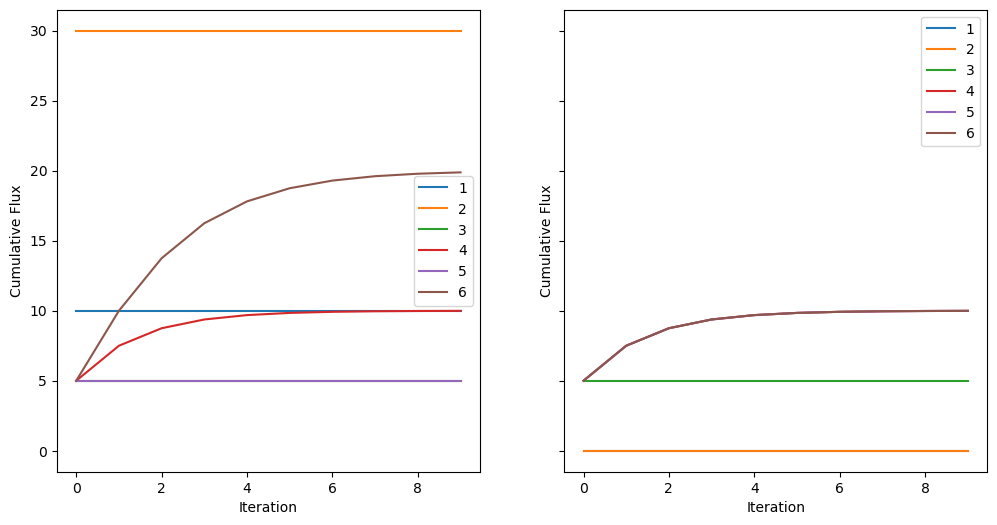

In [4]:
import iifba
from iifba.utils import load_simple_models
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for sit_idx in range(1, 7):
	models, media = load_simple_models(sit_idx)
	print()
	print(sit_idx)
	f, F = iifba.iipfba(models, media, rel_abund="equal", iters=10, flow=0) # defualt values
	print("Media:", media)
	for model in models:
		for reaction in model.reactions:
			print(reaction)
	biomass_id = "exchangeBio1"
	ax1 = iifba.iifba_vis(F.loc[0,:][biomass_id], ax=ax1, line_lab=sit_idx)
	if sit_idx > 2:
		biomass_id = "exchangeBio2"
		ax2 = iifba.iifba_vis(F.loc[1,:][biomass_id], ax=ax2, line_lab=sit_idx)
	else:
		ax2 = iifba.iifba_vis(np.zeros(10), ax=ax2, line_lab=sit_idx)



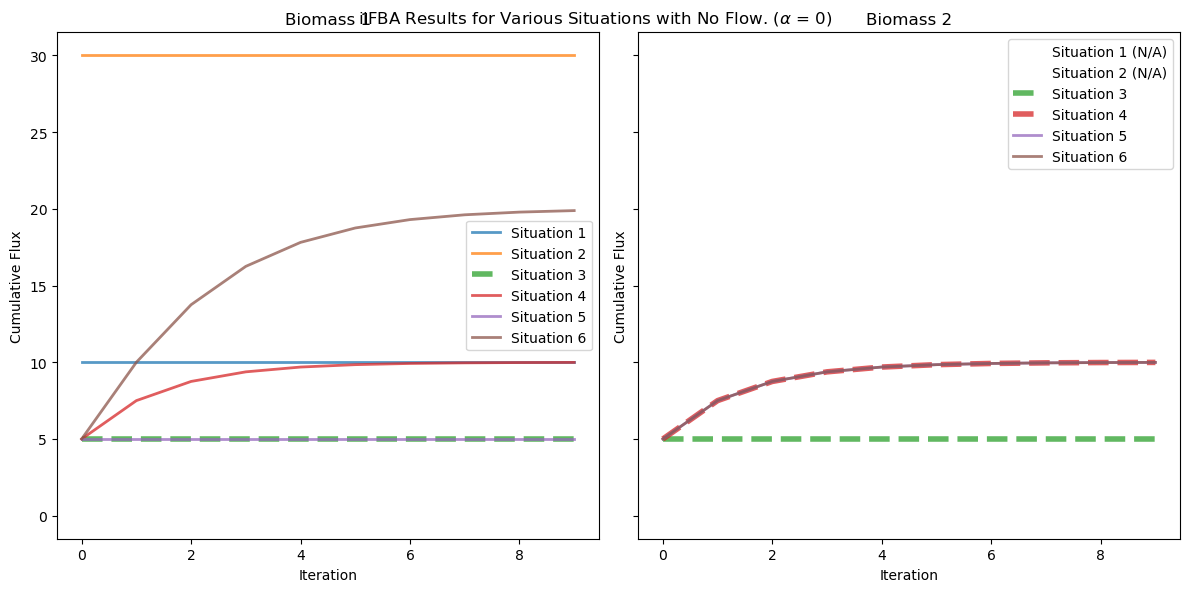

In [5]:
from IPython.display import display
for line in ax1.get_lines():
	line.set_alpha(0.75)  # Set transparency for all lines in ax1
	line.set_lw(2)
for line in ax2.get_lines():
	line.set_alpha(0.75)  # Set transparency for all lines in ax1
	line.set_lw(2)

ax1.get_lines()[2].set_lw(4)# 5 overlaps with 3
ax1.get_lines()[2].set_ls("--")

ax2.get_lines()[3].set_lw(4) # 5 overlaps with 4
ax2.get_lines()[3].set_ls("--")
ax2.get_lines()[2].set_lw(4) # 6 overlaps with 3
ax2.get_lines()[2].set_ls("--")
ax2.get_lines()[0].set_lw(0)
ax2.get_lines()[1].set_lw(0)

# Update legends
ax1.legend(['Situation 1', 'Situation 2', 'Situation 3', 'Situation 4', 'Situation 5', "Situation 6"])
ax2.legend(['Situation 1 (N/A)', 'Situation 2 (N/A)', 'Situation 3', 'Situation 4', 'Situation 5', "Situation 6"])

# Method 3: Get and modify legend properties
legend1 = ax1.get_legend()
legend2 = ax2.get_legend()

# Use display() to show the updated plot
ax1.set_title("Biomass 1")
ax2.set_title("Biomass 2")


fig.tight_layout()
fig.suptitle(r"iiFBA Results for Various Situations with No Flow. ($\alpha$ = 0)")
display(fig)


## Compartmentalized FBA 
Difference arrises due to definition of objective function

Currently: Maximize sum(biomass)

Needs to be: Max sum(biomass) and Maximize individual biomasses.

In [6]:
from cobra import Model

for sit_idx in range(1, 7):
	models, media = load_simple_models(sit_idx)
	print(f"\nSituation {sit_idx} Models:")
	for model in models:
		for ex in model.exchanges:
			ex.lower_bound = 0  # Set lower bound to 0 for all exchange reactions
		for med_ex in media.keys():
			if med_ex in model.reactions:
				model.reactions.get_by_id(med_ex).lower_bound = media[med_ex]
				

	for model_idx, model in enumerate(models):
		# Change compartments for each model so that models[i] uses e0 and c{i+1} compartments
		for met in model.metabolites:
			if met.compartment == "c":
				met.compartment = f"c{model_idx+1}"
				id = met.id.replace("bio1", "bio_c").replace("bio2", "bio_c").replace("_c", f"_c{model_idx+1}")
				met.id = id
		
		for rxn in model.reactions:
			# Change the compartment of the reaction to match the new metabolite compartments
			for met in rxn.metabolites.copy():
				if met.compartment.startswith("c"):
					if not rxn.id.endswith(f"_{met.compartment}"):
					# Find the metabolite object with the new id in the model
						rxn.id = rxn.id + f"_{met.compartment}"

	# Merge the two models into a single compartmentalized model
	comp_model = Model(f"compartmentalized_sit{sit_idx+1}")
	for m in models:
		comp_model.add_metabolites([met.copy() for met in m.metabolites])
		comp_model.add_reactions([rxn.copy() for rxn in m.reactions])


	# Example: print the objective value after optimizing the compartmentalized model
	objective_reactions = [comp_model.reactions.get_by_id(f"exchangeBio{i+1}_c{i+1}") for i in range(len(models))]
	objective_rxns_coef = [1] * len(objective_reactions)

			
	comp_model.objective = dict(zip(objective_reactions, objective_rxns_coef))

	solution = comp_model.optimize()
	print(f"{comp_model.id}, Objective value: {solution.objective_value}")
	print(solution.fluxes)

Ignoring reaction 'Ex_A' since it already exists.
Ignoring reaction 'Ex_A' since it already exists.
Ignoring reaction 'Ex_B' since it already exists.
Ignoring reaction 'Ex_B' since it already exists.



Situation 1 Models:
compartmentalized_sit2, Objective value: 10.0
Ex_A              -10.0
T_A_c1             10.0
BiomassOrg1_c1     10.0
exchangeBio1_c1    10.0
Name: fluxes, dtype: float64

Situation 2 Models:
compartmentalized_sit3, Objective value: 30.0
Ex_A              -10.0
Ex_B              -10.0
T_A_c1             10.0
T_B_c1            -10.0
BiomassFromA_c1    10.0
BiomassFromB_c1    20.0
exchangeBio1_c1    30.0
Name: fluxes, dtype: float64

Situation 3 Models:
compartmentalized_sit4, Objective value: 10.0
Ex_A              -10.0
T_A_c1             10.0
BiomassOrg1_c1     10.0
exchangeBio1_c1    10.0
T_A_c2              0.0
BiomassOrg2_c2      0.0
exchangeBio2_c2     0.0
Name: fluxes, dtype: float64

Situation 4 Models:
compartmentalized_sit5, Objective value: 20.0
Ex_A              -10.0
T_A_c1             10.0
BiomassOrg1_c1     10.0
exchangeBio1_c1    10.0
Ex_B              -10.0
T_B_c2             10.0
BiomassOrg2_c2     10.0
exchangeBio2_c2    10.0
Name: fluxes, dtype: 

**Sit 1 & 2 :**
Matches

**Sit 3:**
Kinda Matches (obj matches, but flux divided incorrectly)
Degenerate solution so any division of metA functions equally (all to the first is simplest)

**Sit 4:**
Matches

**Sit 5:**
Wrong because doesnt account for BiomassFromA_c2 using some A before BiomassFromA_c1 can get to it... 15 iiFBA makes more sense

**Sit 6:**
Matches

situation   iifba bio1   cfba bio1   iifba bio2     cfba bio2       iifba sum    cfba sum
1               10          10          na              na              10          10
2               20          20          na              na              20          20
3               5           10          5               0               10          10
4               10          10          10              10              20          20
5               5           10          10              10              15          20      
6				20			20			10				10				30			30